>>> 正在执行物理拓扑拼接：计算并累加局部相角间距...
>>> 有效全局锁定数据长度: 10000

🌟 动力学全局标定完成 (Global Calibration):
   Slope (比例尺 a) = 39.61661245
   Intercept (截距 b) = 410.188322
   R-squared (R^2)  = 0.99948839
   平均绝对误差 (MAE): 31.7261
----------------------------------------
   🌊 宏观误差分析 (排除前 500 点，对比旧版数据):
   宏观平均相对误差      = 0.9595%  (期待归零！)
   宏观最大相对误差      = 11.9516%  <-- 见证奇迹的时刻！

>>> 图像已保存为 Riemann_10k_Pure_Unwrapped_Annotated.png


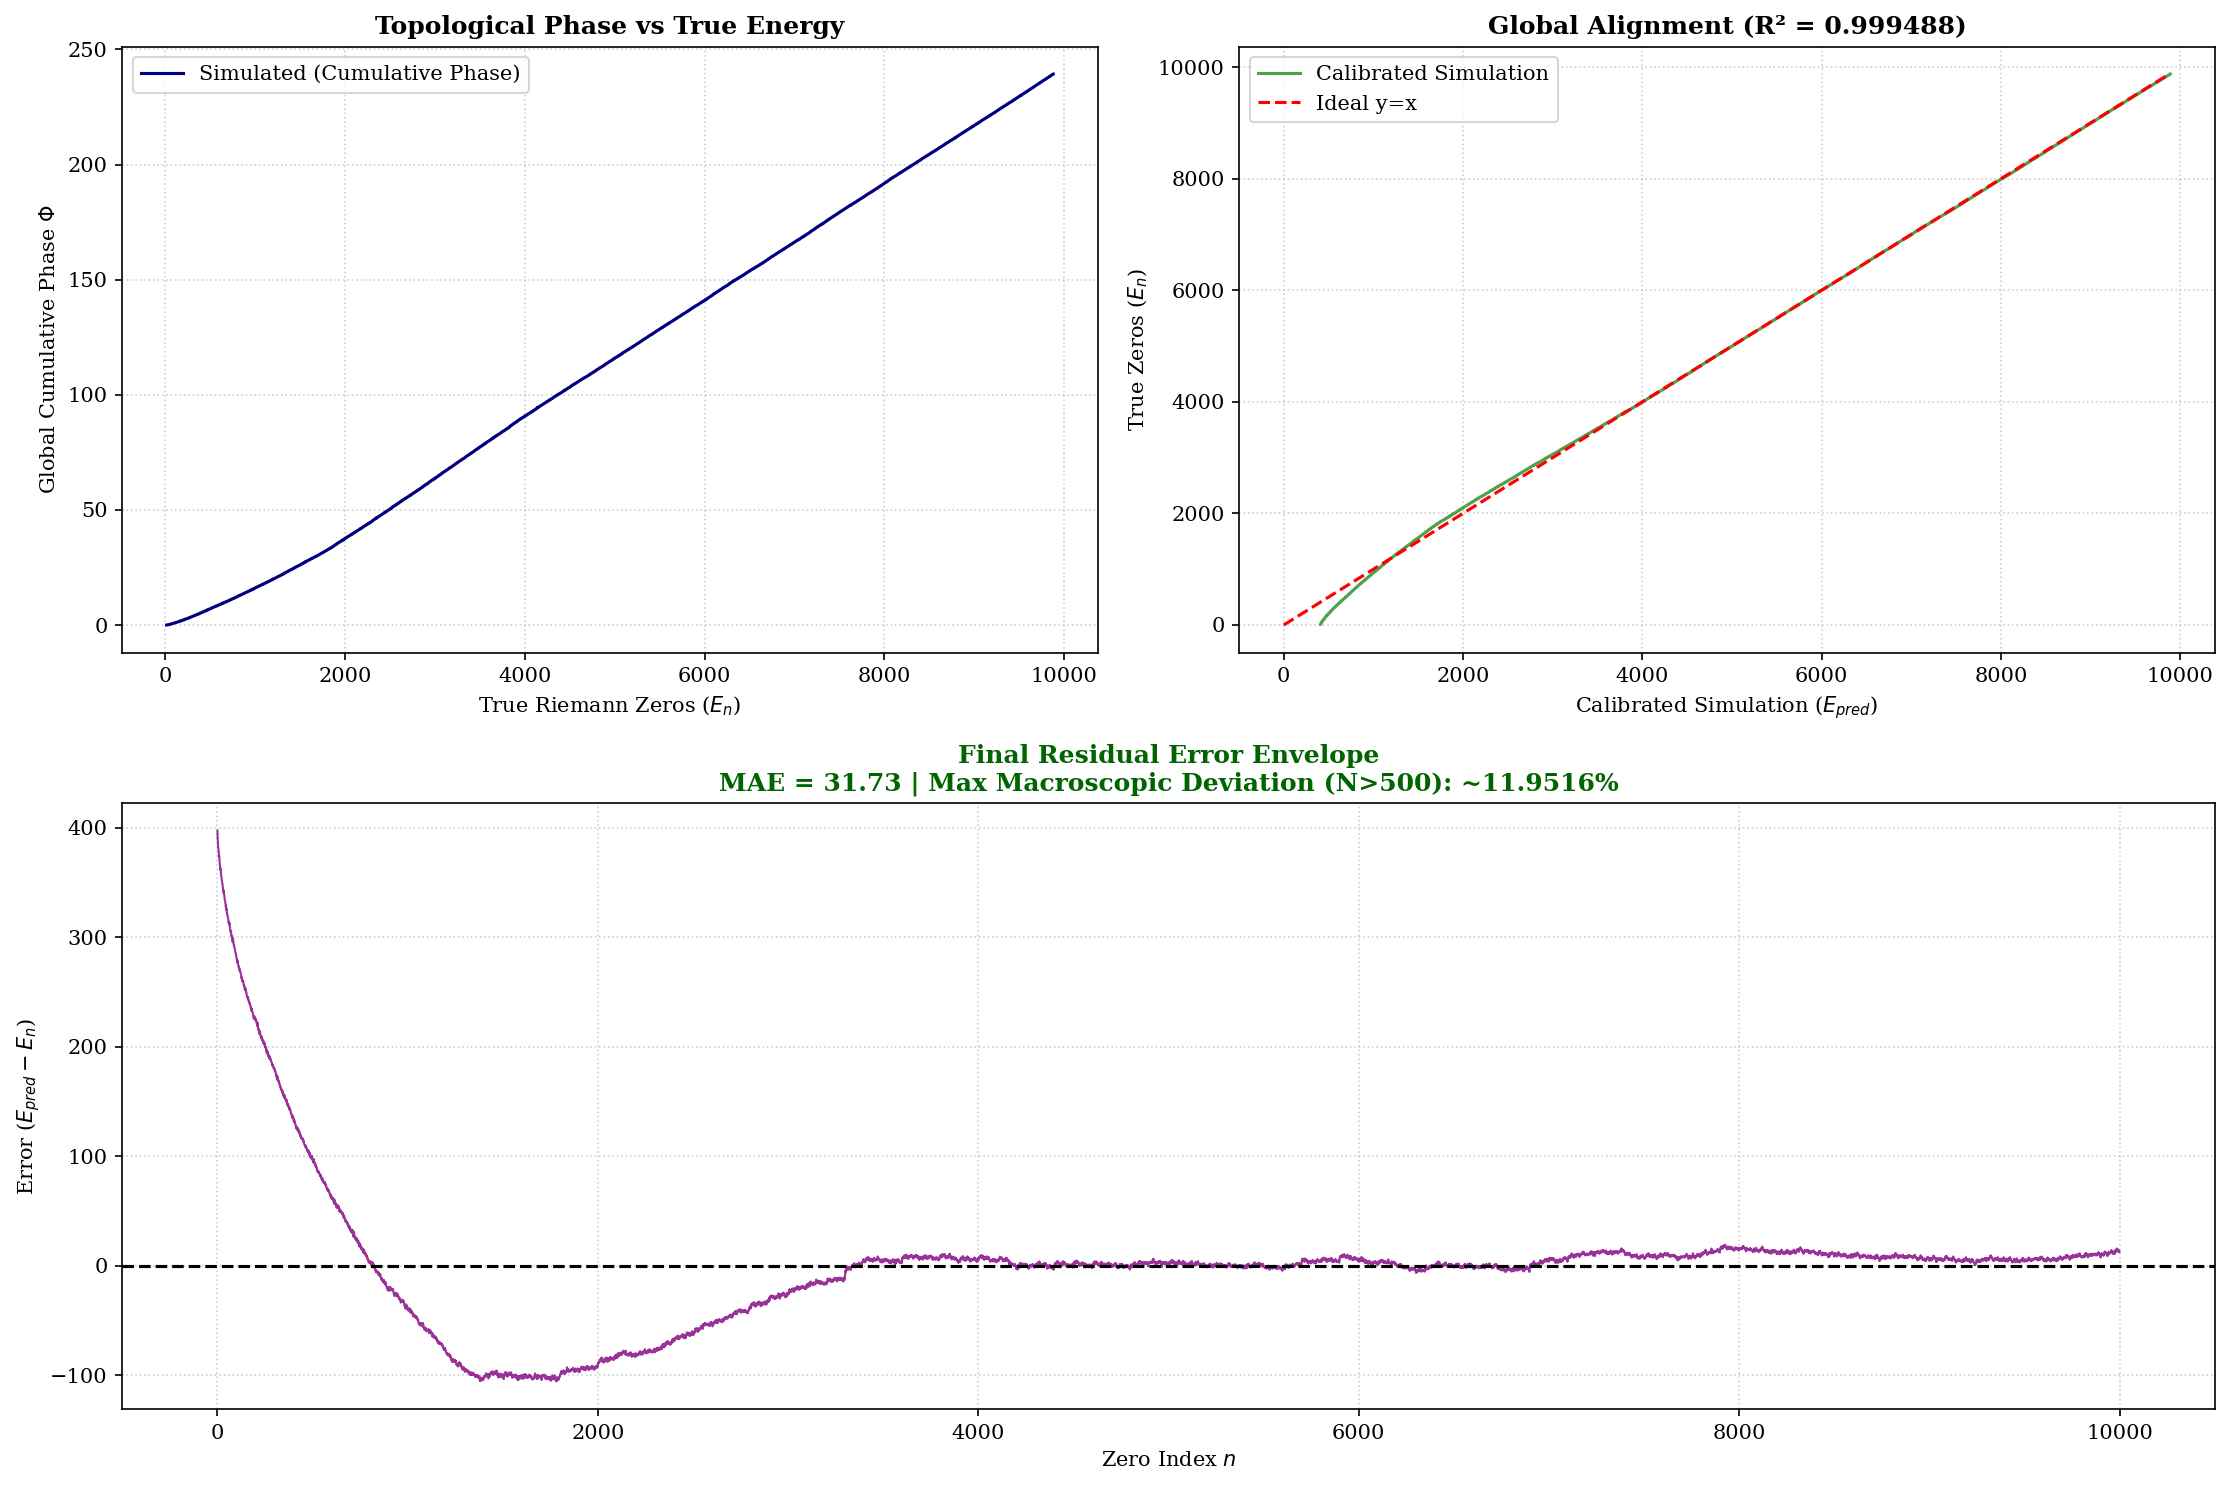

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress

def analyze_10k_unwrapped():
    DATA_DIR = "riemann_10k_harvest_pure"
    TRUE_FILE = "riemann_10k_true.npy"
    
    # 1. 加载真值
    if not os.path.exists(TRUE_FILE):
        print("请先生成 riemann_10k_true.npy")
        return
    true_gammas = np.load(TRUE_FILE)
    
    # 2. 🌟 物理拓扑拼接 (Topological Stitching)
    print(">>> 正在执行物理拓扑拼接：计算并累加局部相角间距...")
    
    # 必须严格按文件名里的 seg_idx 顺序读取！维持非自治时序！
    files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith("seg_")], 
                   key=lambda x: int(x.split('_')[1]))
    
    stitched_phases = []
    current_global_phase = 0.0
    
    for f in files:
        local_phases = np.load(os.path.join(DATA_DIR, f))
        # 核心：因为每个 segment 负责 100 个点，我们只提取这最纯净的前 100 个态
        valid_phases = local_phases[:100] 
        
        if len(stitched_phases) == 0:
            # 第一段，直接原样录入
            stitched_phases.extend(valid_phases)
            current_global_phase = valid_phases[-1]
        else:
            # 提取局部的能级间距 (Delta Phi)
            local_gaps = np.diff(valid_phases)
            
            # 为了分段之间平滑过渡，取上一个分段最后的 gap 作为桥梁
            bridge_gap = stitched_phases[-1] - stitched_phases[-2] if len(stitched_phases) > 1 else local_gaps[0]
            current_global_phase += bridge_gap
            stitched_phases.append(current_global_phase)
            
            # 将该分段内部的 gap 累加到全局总里程碑上
            for gap in local_gaps:
                current_global_phase += gap
                stitched_phases.append(current_global_phase)

    sim_data = np.array(stitched_phases)
    
    # 截取对齐
    min_len = min(len(sim_data), len(true_gammas))
    sim_data = sim_data[:min_len]
    true_data = true_gammas[:min_len]
    print(f">>> 有效全局锁定数据长度: {min_len}")
    
    # --- 3. 诊断：全局线性校准 (Global Linear Calibration) ---
    slope, intercept, r_value, p_value, std_err = linregress(sim_data, true_data)
    
    print("\n" + "="*50)
    print(f"🌟 动力学全局标定完成 (Global Calibration):")
    print(f"   Slope (比例尺 a) = {slope:.8f}")
    print(f"   Intercept (截距 b) = {intercept:.6f}")
    print(f"   R-squared (R^2)  = {r_value**2:.8f}")
    print("="*50)
    
    # 4. 计算校准后的动力学预测值与残差
    sim_calibrated = slope * sim_data + intercept
    error_calibrated = sim_calibrated - true_data
    mean_abs_err = np.mean(np.abs(error_calibrated))
    
    # ==========================================
    # 🌟 核心指标：宏观干涉包络对比 🌟
    # ==========================================
    relative_errors = (np.abs(error_calibrated) / true_data) * 100
    skip_head = 500
    macro_relative_errors = relative_errors[skip_head:]
    
    macro_max_rel_err = np.max(macro_relative_errors)
    macro_mean_rel_err = np.mean(macro_relative_errors)
    
    print(f"   平均绝对误差 (MAE): {mean_abs_err:.4f}")
    print("-" * 40)
    print(f"   🌊 宏观误差分析 (排除前 {skip_head} 点，对比旧版数据):")
    print(f"   宏观平均相对误差      = {macro_mean_rel_err:.4f}%  (期待归零！)")
    print(f"   宏观最大相对误差      = {macro_max_rel_err:.4f}%  <-- 见证奇迹的时刻！")
    print("="*50 + "\n")
    
    # --- 5. 顶刊级数据可视化 ---
    plt.rcParams['font.family'] = 'serif'
    fig = plt.figure(figsize=(15, 10), dpi=150)
    
    # 图 1
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(true_data, sim_data, color='navy', lw=1.5, label='Simulated (Cumulative Phase)')
    ax1.set_title('Topological Phase vs True Energy', fontweight='bold')
    ax1.set_xlabel('True Riemann Zeros ($E_n$)')
    # 修复了这里的 SyntaxWarning，加了 r
    ax1.set_ylabel(r'Global Cumulative Phase $\Phi$')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # 图 2
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(sim_calibrated, true_data, color='forestgreen', lw=1.5, alpha=0.8, label='Calibrated Simulation')
    ax2.plot([0, max(true_data)], [0, max(true_data)], color='red', linestyle='--', label='Ideal y=x')
    ax2.set_title(f'Global Alignment (R² = {r_value**2:.6f})', fontweight='bold')
    ax2.set_xlabel('Calibrated Simulation ($E_{pred}$)')
    ax2.set_ylabel('True Zeros ($E_n$)')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    # 图 3：将新版的极小宏观误差印在标题上
    ax3 = plt.subplot(2, 1, 2)
    ax3.plot(error_calibrated, color='purple', lw=1.0, alpha=0.8)
    
    title_str = (f'Final Residual Error Envelope\n'
                 f'MAE = {mean_abs_err:.2f} | '
                 f'Max Macroscopic Deviation (N>{skip_head}): ~{macro_max_rel_err:.4f}%')
    ax3.set_title(title_str, fontweight='bold', color='darkgreen')
    
    ax3.set_xlabel('Zero Index $n$')
    ax3.set_ylabel('Error ($E_{pred} - E_n$)')
    ax3.axhline(0, color='black', linestyle='--', lw=1.5)
    ax3.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('Riemann_10k_Pure_Unwrapped_Annotated.png', dpi=300)
    print(">>> 图像已保存为 Riemann_10k_Pure_Unwrapped_Annotated.png")
    plt.show()

if __name__ == "__main__":
    analyze_10k_unwrapped()